In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.1 MB/s eta 0:00:00


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR

data = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
data.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65,1,4,49500
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70,3,5,55000


In [48]:
df = data.copy()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7565 non-null   object
 1   district    7565 non-null   object
 2   rooms       7565 non-null   int64 
 3   size        7565 non-null   object
 4   level       7565 non-null   int64 
 5   max_levels  7565 non-null   int64 
 6   price       7565 non-null   object
dtypes: int64(3), object(4)
memory usage: 413.8+ KB


In [50]:
df.isna().sum()

,0
location,0
district,0
rooms,0
size,0
level,0
max_levels,0
price,0


In [51]:
df.isnull().sum()

,0
location,0
district,0
rooms,0
size,0
level,0
max_levels,0
price,0


In [52]:
df.describe()

,rooms,level,max_levels
count,7565.000000,7565.000000,7565.000000
mean,2.625644,3.699273,6.038202
std,1.085201,2.237275,2.613271
min,1.000000,1.000000,1.000000
25%,2.000000,2.000000,4.000000
50%,3.000000,3.000000,5.000000
75%,3.000000,5.000000,9.000000
max,10.000000,19.000000,25.000000


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7565 non-null   object
 1   district    7565 non-null   object
 2   rooms       7565 non-null   int64 
 3   size        7565 non-null   object
 4   level       7565 non-null   int64 
 5   max_levels  7565 non-null   int64 
 6   price       7565 non-null   object
dtypes: int64(3), object(4)
memory usage: 413.8+ KB


In [54]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['size'] = pd.to_numeric(df['size'], errors='coerce').fillna(0).astype(int)
df = df[(df['size']<400) & (df['rooms']<9) & (df['price']<400000)]

In [55]:
df.describe()

,rooms,size,level,max_levels,price
count,7429.000000,7429.000000,7429.000000,7429.000000,7429.000000
mean,2.613407,72.540988,3.695248,6.026787,58169.298021
std,1.061498,34.972442,2.237153,2.609004,41838.151535
min,1.000000,0.000000,1.000000,1.000000,2.000000
25%,2.000000,50.000000,2.000000,4.000000,35000.000000
50%,3.000000,65.000000,3.000000,5.000000,46000.000000
75%,3.000000,85.000000,5.000000,9.000000,66000.000000
max,8.000000,360.000000,19.000000,25.000000,395000.000000


In [56]:
corr_df = df.select_dtypes(include=['int64', 'float64'])
corr = corr_df.corr()['price'].sort_values(ascending=False)
corr

,price
price,1.000000
size,0.791563
rooms,0.566029
max_levels,0.238956
level,0.064124


In [57]:
df['price_per_kv'] = df['price'] / df['size']
df['size_per_room'] = df['size'] / df['rooms']
df["floor_ratio"] = df["level"] / df["max_levels"]
df['mean_price_per_district'] = df.groupby('district')['price'].transform('mean')


In [58]:
corr_df = df.select_dtypes(include=[np.number])
corr = corr_df.corr()['price'].sort_values(ascending=False)
corr

,price
price,1.000000
size,0.791563
rooms,0.566029
mean_price_per_district,0.344407
size_per_room,0.326716
max_levels,0.238956
price_per_kv,0.206351
level,0.064124
floor_ratio,-0.128903


In [59]:
df_num = df.select_dtypes(include=[np.number])

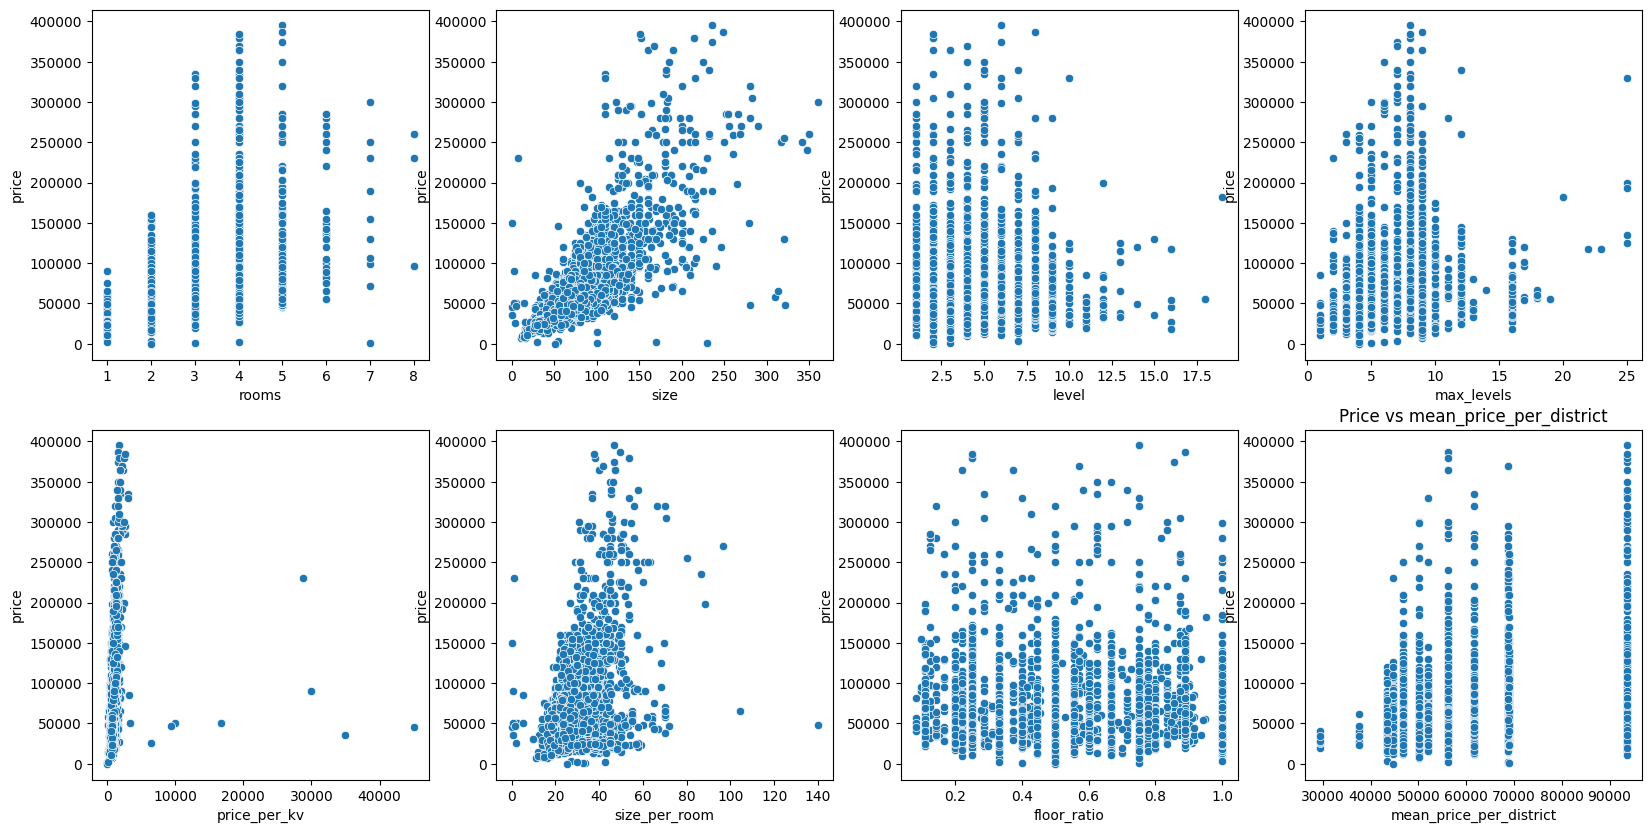

In [60]:
df_no_price = df_num.drop('price', axis=1)
fig, ax =  plt.subplots(2,4, figsize=(20,10))
ax = ax.flatten()
for i, col in enumerate(df_no_price.columns):
    sns.scatterplot(ax=ax[i], data=df, x=col, y='price')
    plt.title(f'Price vs {col}')


In [61]:
df_one_hot = pd.get_dummies(df[['district']], drop_first=True)
df_ready = pd.concat([df_num, df_one_hot], axis=1)
df_ready = df_ready.drop(5347)

In [62]:
x = df_ready.drop('price', axis=1)
y = df_ready['price']

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)


In [64]:
data.head(3)

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000


In [68]:
class NumericFilter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['price'] = pd.to_numeric(X['price'], errors='coerce')
        X['size'] = pd.to_numeric(X['size'], errors='coerce').fillna(0).astype(int)
        X = X[(X['size'] < 400) & (X['rooms'] < 9) & (X['price'] < 400000)]
        return X


class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['price_per_kv'] = X['price'] / X['size']
        X['size_per_room'] = X['size'] / X['rooms']
        X["floor_ratio"] = X["level"] / X["max_levels"]
        X['mean_price_per_district'] = X.groupby('district')['price'].transform('mean')
        return X

class FullTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_row=5347):
        self.drop_row = drop_row
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X['price'] = pd.to_numeric(X['price'], errors='coerce')
        X['size'] = pd.to_numeric(X['size'], errors='coerce').fillna(0).astype(int)
        X = X[(X['size'] < 400) & (X['rooms'] < 9) & (X['price'] < 400000)]

        X['price_per_kv'] = X['price'] / X['size']
        X['size_per_room'] = X['size'] / X['rooms']
        X['floor_ratio'] = X['level'] / X['max_levels']
        X['mean_price_per_district'] = X.groupby('district')['price'].transform('mean')

        df_num = X.select_dtypes(include=[np.number])
        df_one_hot = pd.get_dummies(X[['district']], drop_first=True)
        df_ready = pd.concat([df_num, df_one_hot], axis=1)

        if self.drop_row is not None and self.drop_row in df_ready.index:
            df_ready = df_ready.drop(self.drop_row)

        X_scaled = self.scaler.fit_transform(df_ready.drop('price', axis=1))
        y = df_ready['price'].values

        return X_scaled, y



In [69]:
transformer = FullTransformer()
x, y = transformer.fit_transform(data)

In [70]:
print(x.shape)
print(y.shape)

(7428, 19)
(7428,)


In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [72]:
x_test.shape

(1486, 19)

In [74]:
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'SVR': SVR()
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = {}

mean_y = np.mean(y)

for name, model in models.items():
    print(f"Working on {name} ...")
    scores = -cross_val_score(model, x, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(scores)
    mean_rmse = rmse_scores.mean()
    avg_percentage_error = (mean_rmse / mean_y) * 100
    results[name] = (mean_rmse, avg_percentage_error)

sorted_results = dict(sorted(results.items(), key=lambda x: x[1][0]))

for model_name, (rmse, perc_error) in sorted_results.items():
    print(f"{model_name}: RMSE = {rmse:.2f}, Avg % error = {perc_error:.2f}%")

Working on LinearRegression ...
Working on DecisionTree ...
Working on RandomForest ...
Working on GradientBoosting ...
Working on XGBoost ...
Working on CatBoost ...
Working on SVR ...
CatBoost: RMSE = 2614.26, Avg % error = 4.50%
RandomForest: RMSE = 3229.98, Avg % error = 5.55%
GradientBoosting: RMSE = 3360.81, Avg % error = 5.78%
XGBoost: RMSE = 3533.83, Avg % error = 6.08%
DecisionTree: RMSE = 4569.87, Avg % error = 7.86%
LinearRegression: RMSE = 23682.51, Avg % error = 40.72%
SVR: RMSE = 43194.36, Avg % error = 74.27%


In [75]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(x_train, y_train)

y_train_pred = cat_model.predict(x_train)
y_test_pred = cat_model.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")


Train RMSE: 541.45, R²: 0.9998
Test RMSE: 1917.96, R²: 0.9978


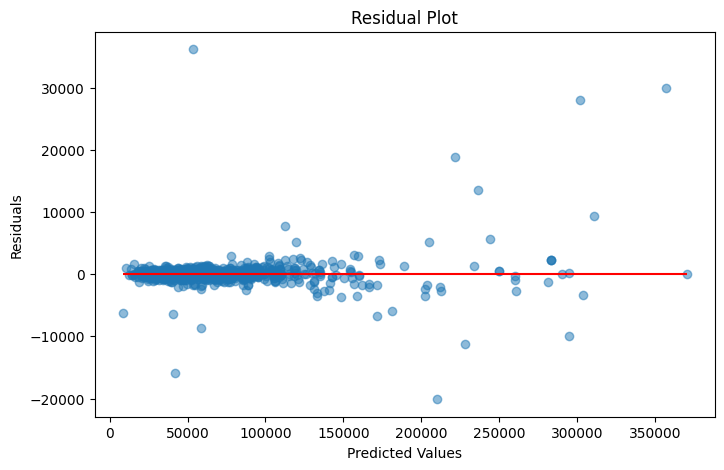

In [76]:
residuals = y_test - y_test_pred
plt.figure(figsize=(8,5))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_test_pred), xmax=max(y_test_pred), colors='r')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [83]:
y_pred = cat_model.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

r2 = r2_score(y_test, y_pred)
print("R² score:", r2)

avg_error = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Avr Error:", avg_error, "%")


RMSE: 1917.9561304947367
MAE: 577.5966953434738
R² score: 0.9977709519703839
Avr Error: 1.076825937676878 %


In [84]:
y_train_pred = cat_model.predict(x_train)
y_test_pred = cat_model.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

train_avg_error = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_avg_error = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"Train Avg % Error: {train_avg_error:.2f}%")
print(f"Test Avg % Error: {test_avg_error:.2f}%")


Train RMSE: 541.45
Test RMSE: 1917.96
Train Avg % Error: 26.27%
Test Avg % Error: 1.08%


In [87]:
cat = CatBoostRegressor(verbose=0, random_state=42)

param_grid = {
    'depth': [4, 6, 8, 10],
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

rand_search = RandomizedSearchCV(
    estimator=cat,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(x_train, y_train)

print("Best params:", rand_search.best_params_)
print("Best RMSE:", -rand_search.best_score_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best params: {'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 1500, 'depth': 4}
Best RMSE: 3589.0494294123896


In [88]:
final_cat = CatBoostRegressor(
    learning_rate=0.03,
    l2_leaf_reg=3,
    iterations=1500,
    depth=4,
    verbose=0,
    random_state=42
)
final_cat.fit(x_train, y_train)

y_train_pred = final_cat.predict(x_train)
y_test_pred = final_cat.predict(x_test)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_avg_error = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_avg_error = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}, Avg % Error: {train_avg_error:.2f}%")
print(f"Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}, Avg % Error: {test_avg_error:.2f}%")


Train RMSE: 895.30, MAE: 536.26, R²: 0.9995, Avg % Error: 62.48%
Test RMSE: 1819.20, MAE: 653.29, R²: 0.9980, Avg % Error: 1.23%


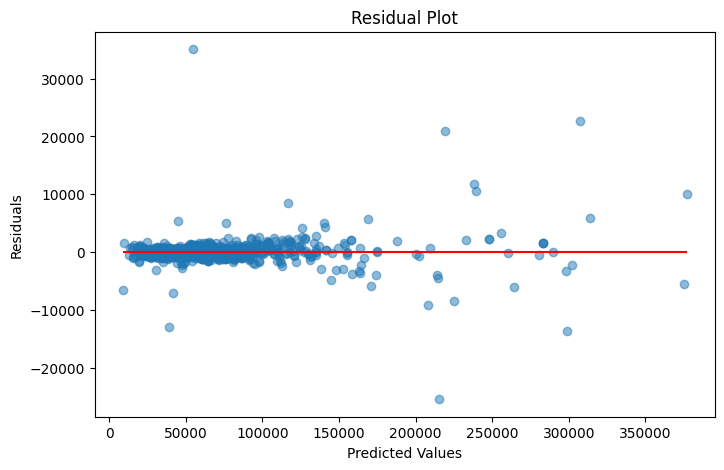

In [89]:
residuals = y_test - y_test_pred
plt.figure(figsize=(8,5))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=min(y_test_pred), xmax=max(y_test_pred), colors='r')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [90]:
import joblib

joblib.dump(final_cat, "catboost_model.pkl")


['catboost_model.pkl']